In [13]:
# Import libraries
import requests
# for data manipulation and analysis
import pandas as pd
#convert the response as a strcuctured json
import json
#for getting coordinates
from geopy.geocoders import Nominatim
#mathematical operations on lists
import numpy as np
#parse the datetimes we get from NOAA
from datetime import datetime
#format the dates
from matplotlib.dates import DateFormatter
#For data visualization
import matplotlib.pyplot as plt
import seaborn as sns
# For forecasting
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

In [14]:
# NASA API base URL
base_url = "https://power.larc.nasa.gov/api/temporal/daily/point"

In [15]:
# Parameters for the API request
parameters = "PRECTOTCORR,GWETTOP,T2M"
community = "AG"
startdate = "20180101"
enddate = "20221201"
places_list = ["Dhaka", "Chittagong", "Rajshahi", "Rangpur","Khulna","Sylhet","Barishal"]

In [16]:
# Get the coordinates (longitude, latitude) of listed places
def get_coordinates(place_name):
    geolocator = Nominatim(user_agent="my_geocoder")
    location = geolocator.geocode(place_name)

    if location:
        latitude = location.latitude
        longitude = location.longitude
        return latitude, longitude
    else:
        return None

regions = []

for place in places_list:
    latitude, longitude = get_coordinates(place)

    if (latitude, longitude):
        regions.append((latitude, longitude, place))
    else:
        regions.append((None, None, None))

print("Place Coordinates:")
for latitude, longitude, place in regions:
    print(f"{place}: Latitude {latitude}, Longitude {longitude}")

regions


Place Coordinates:
Dhaka: Latitude 23.7644025, Longitude 90.389015
Chittagong: Latitude 22.333778, Longitude 91.8344348
Rajshahi: Latitude 24.6285432, Longitude 89.0376862
Rangpur: Latitude 25.6376135, Longitude 89.0826381
Khulna: Latitude 22.9372087, Longitude 89.2852741
Sylhet: Latitude 24.7358854, Longitude 91.6852476
Barishal: Latitude 22.4934035, Longitude 90.3548015


[(23.7644025, 90.389015, 'Dhaka'),
 (22.333778, 91.8344348, 'Chittagong'),
 (24.6285432, 89.0376862, 'Rajshahi'),
 (25.6376135, 89.0826381, 'Rangpur'),
 (22.9372087, 89.2852741, 'Khulna'),
 (24.7358854, 91.6852476, 'Sylhet'),
 (22.4934035, 90.3548015, 'Barishal')]

In [17]:
data =[]
# Loop through each longitude and latitude pair and make API calls
for latitude, longitude, place in regions:
    url = f"{base_url}?parameters={parameters}&community={community}&longitude={longitude}&latitude={latitude}&start={startdate}&end={enddate}&format=JSON"
    response = requests.get(url)

    if response.status_code == 200:
        da = json.loads(response.text)
        data.append(da)


        # Process the data as needed
        print(f"Data for Longitude: {longitude}, Latitude: {latitude}")
        # ... process the data here ...
    else:
        print(f"Error: Failed to download data for Longitude: {longitude}, Latitude: {latitude}")

data


Data for Longitude: 90.389015, Latitude: 23.7644025
Data for Longitude: 91.8344348, Latitude: 22.333778
Data for Longitude: 89.0376862, Latitude: 24.6285432
Data for Longitude: 89.0826381, Latitude: 25.6376135
Data for Longitude: 89.2852741, Latitude: 22.9372087
Data for Longitude: 91.6852476, Latitude: 24.7358854
Data for Longitude: 90.3548015, Latitude: 22.4934035


[{'type': 'Feature',
  'geometry': {'type': 'Point', 'coordinates': [90.389015, 23.7644025, 10.06]},
  'properties': {'parameter': {'PRECTOTCORR': {'20180101': 0.0,
     '20180102': 0.47,
     '20180103': 1.42,
     '20180104': 3.58,
     '20180105': 0.0,
     '20180106': 0.0,
     '20180107': 0.0,
     '20180108': 0.0,
     '20180109': 0.0,
     '20180110': 0.0,
     '20180111': 0.0,
     '20180112': 0.0,
     '20180113': 0.0,
     '20180114': 0.0,
     '20180115': 0.0,
     '20180116': 0.0,
     '20180117': 0.0,
     '20180118': 0.0,
     '20180119': 0.0,
     '20180120': 0.0,
     '20180121': 0.0,
     '20180122': 0.0,
     '20180123': 0.0,
     '20180124': 0.0,
     '20180125': 0.0,
     '20180126': 0.0,
     '20180127': 0.0,
     '20180128': 0.0,
     '20180129': 0.0,
     '20180130': 0.0,
     '20180131': 0.0,
     '20180201': 0.0,
     '20180202': 0.0,
     '20180203': 0.0,
     '20180204': 0.0,
     '20180205': 0.0,
     '20180206': 0.0,
     '20180207': 0.0,
     '20180208': 0

In [18]:
result_list = []

for entry in data:
    coordinates = entry['geometry']['coordinates']
    longitude, latitude, _ = coordinates

    for param_type, param_data in entry['properties']['parameter'].items():
        for date, value in param_data.items():
            param_units = entry['parameters'][param_type]['units']
            param_longname = entry['parameters'][param_type]['longname']

            result_list.append({
                'Longitude': longitude,
                'Latitude': latitude,
                'Date': datetime.strptime(date,'%Y%m%d'), # Convert the 'Date' column to datetime format
                'Parameters': param_type,
                'Values': value,
                'Units': param_units,
                'Longname': param_longname
            })

df1 = pd.DataFrame(result_list)

# Create a DataFrame for places
places_df = pd.DataFrame(regions, columns=["Latitude", "Longitude", "Place"])

# Merge the two DataFrames
df = pd.merge(df1, places_df, on=["Latitude", "Longitude"], how="left")

# Position the "Place" column as the first column
df.insert(0, "Place", df.pop("Place"))

df.head()


,Place,Longitude,Latitude,Date,Parameters,Values,Units,Longname
0,Dhaka,90.389015,23.764402,2018-01-01,PRECTOTCORR,0.00,mm/day,Precipitation Corrected
1,Dhaka,90.389015,23.764402,2018-01-02,PRECTOTCORR,0.47,mm/day,Precipitation Corrected
2,Dhaka,90.389015,23.764402,2018-01-03,PRECTOTCORR,1.42,mm/day,Precipitation Corrected
3,Dhaka,90.389015,23.764402,2018-01-04,PRECTOTCORR,3.58,mm/day,Precipitation Corrected
4,Dhaka,90.389015,23.764402,2018-01-05,PRECTOTCORR,0.00,mm/day,Precipitation Corrected


In [19]:
# Pivot the DataFrame to have unique parameters as columns
df_pivot = df.pivot_table(index=['Place', 'Longitude', 'Latitude', 'Date'], columns='Parameters', values='Values', aggfunc='first').reset_index()

# Rename the columns to include long name and units
new_columns = []
for column in df_pivot.columns:
    if column in ['Place', 'Longitude', 'Latitude', 'Date']:
        new_columns.append(column)
    else:
        longname = df[df['Parameters'] == column]['Longname'].iloc[0]
        units = df[df['Parameters'] == column]['Units'].iloc[0]
        new_columns.append(f'{longname} ({units})')

df_pivot.columns = new_columns

df_pivot

,Place,Longitude,Latitude,Date,Surface Soil Wetness (1),Precipitation Corrected (mm/day),Temperature at 2 Meters (C)
0,Barishal,90.354801,22.493403,2018-01-01,0.80,0.88,19.58
1,Barishal,90.354801,22.493403,2018-01-02,0.80,1.90,18.72
2,Barishal,90.354801,22.493403,2018-01-03,0.79,0.25,17.60
3,Barishal,90.354801,22.493403,2018-01-04,0.79,0.35,15.56
4,Barishal,90.354801,22.493403,2018-01-05,0.78,0.00,15.30
...,...,...,...,...,...,...,...
12567,Sylhet,91.685248,24.735885,2022-11-27,0.80,0.00,21.38
12568,Sylhet,91.685248,24.735885,2022-11-28,0.80,0.00,21.41
12569,Sylhet,91.685248,24.735885,2022-11-29,0.80,0.00,23.52
12570,Sylhet,91.685248,24.735885,2022-11-30,0.80,0.00,23.87


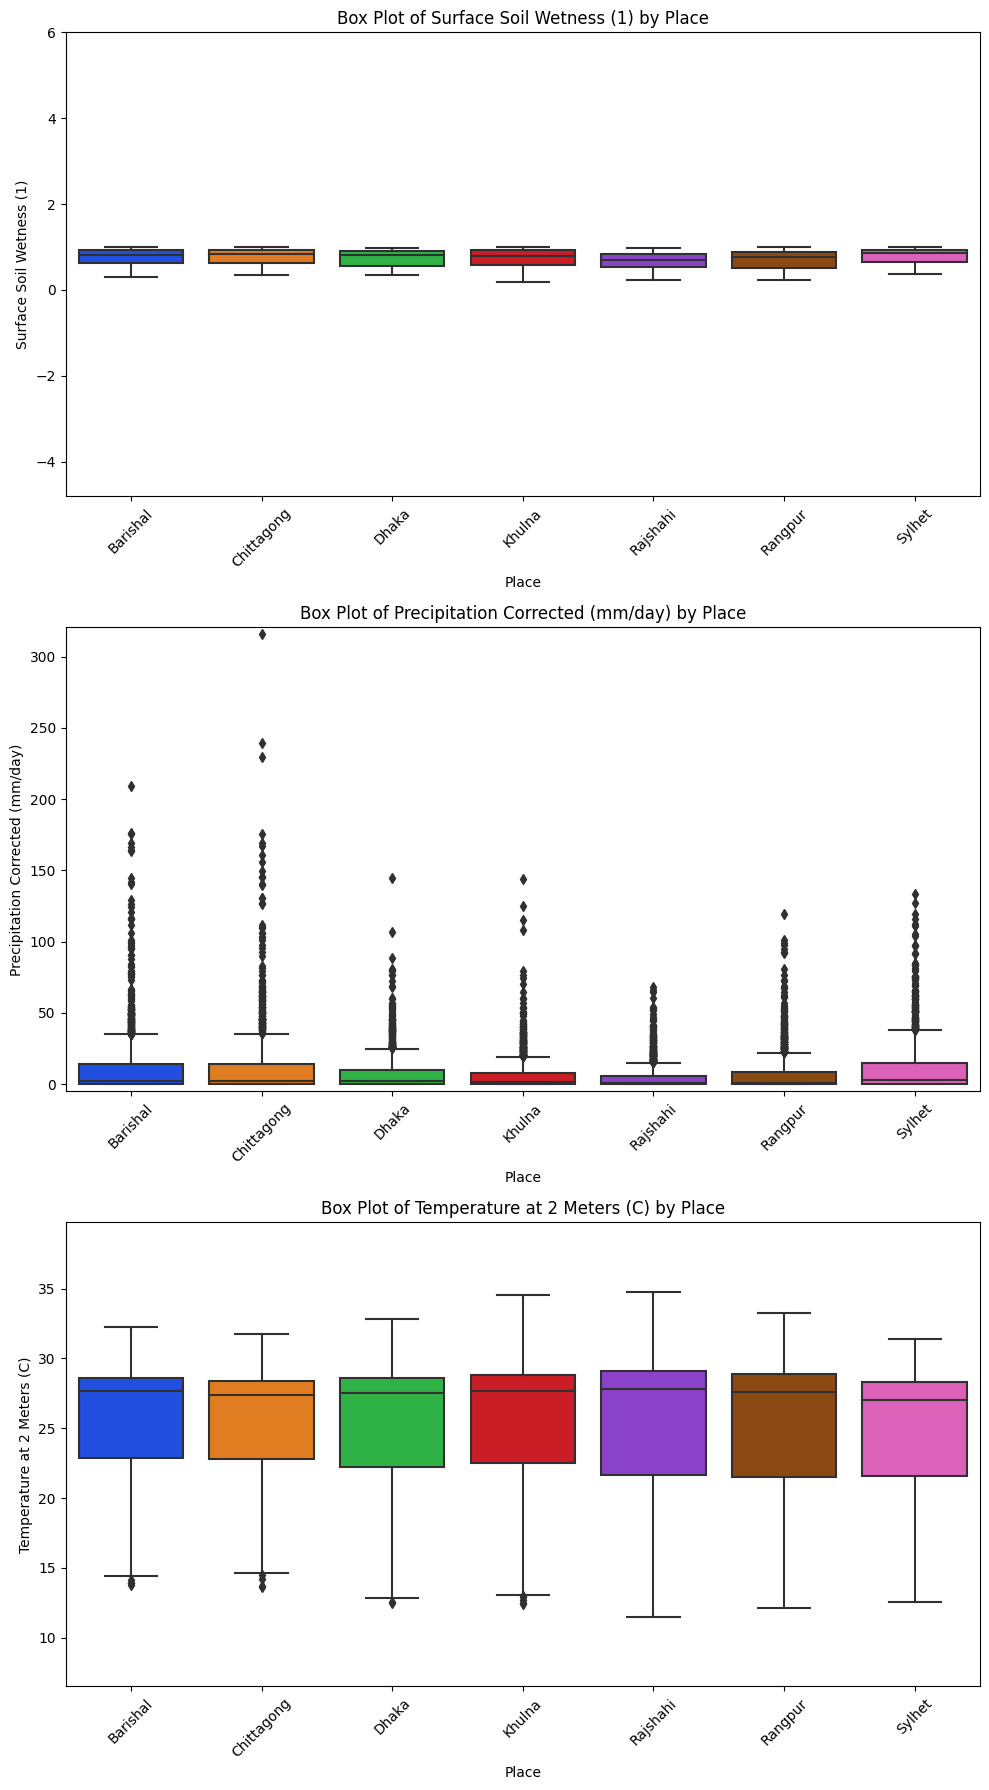

<Figure size 640x480 with 0 Axes>

In [20]:
# List of parameters in your DataFrame
parameters = df_pivot.columns[4:]  # Assuming the parameter columns start from index 4

# Create subplots based on the number of parameters
num_parameters = len(parameters)
fig, axes = plt.subplots(nrows=num_parameters, figsize=(10, 6 * num_parameters))

# Iterate over each parameter and create a box plot
for i, parameter in enumerate(parameters):
    ax = axes[i]
    sns.boxplot(x="Place", y=parameter, data=df_pivot, ax=ax)
    ax.set_title(f"Box Plot of {parameter} by Place")
    ax.set_xlabel("Place")
    ax.set_ylabel(parameter)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.set_ylim(df_pivot[parameter].min() - 5, df_pivot[parameter].max() + 5)  # Adjust y-axis limits for better visualization

plt.tight_layout()
plt.show()
# Save the plot as a JPEG image
folder="D:\Python practice\Justice in data summer group\Presentation"
plot_filename = f"{folder}{parameter}_plot.jpg"
plt.savefig(plot_filename, format="jpeg")

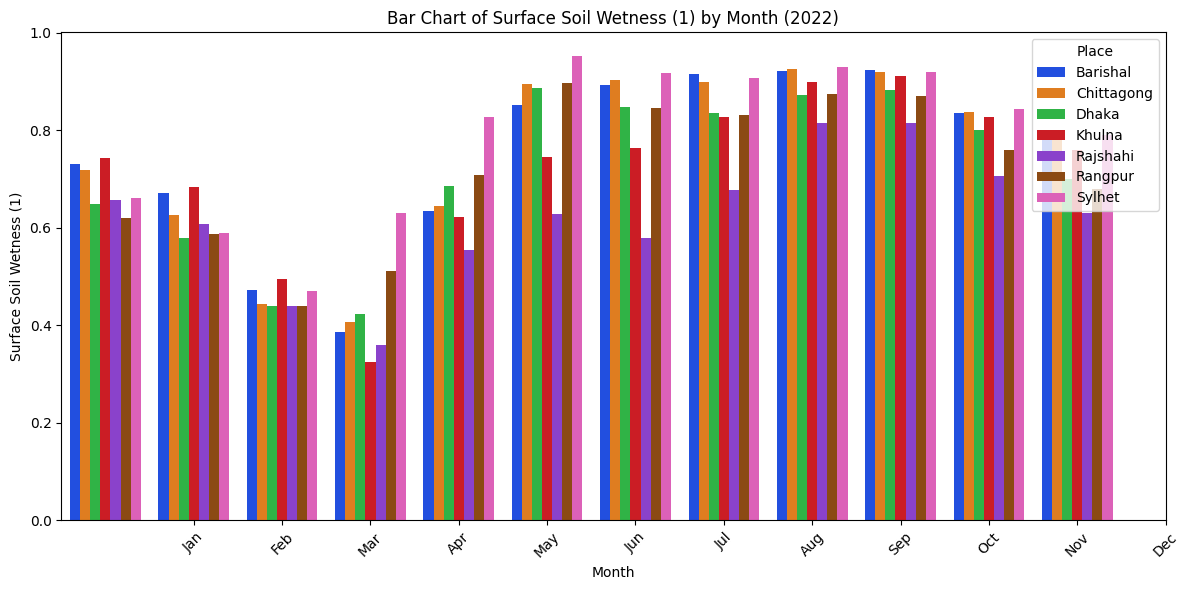

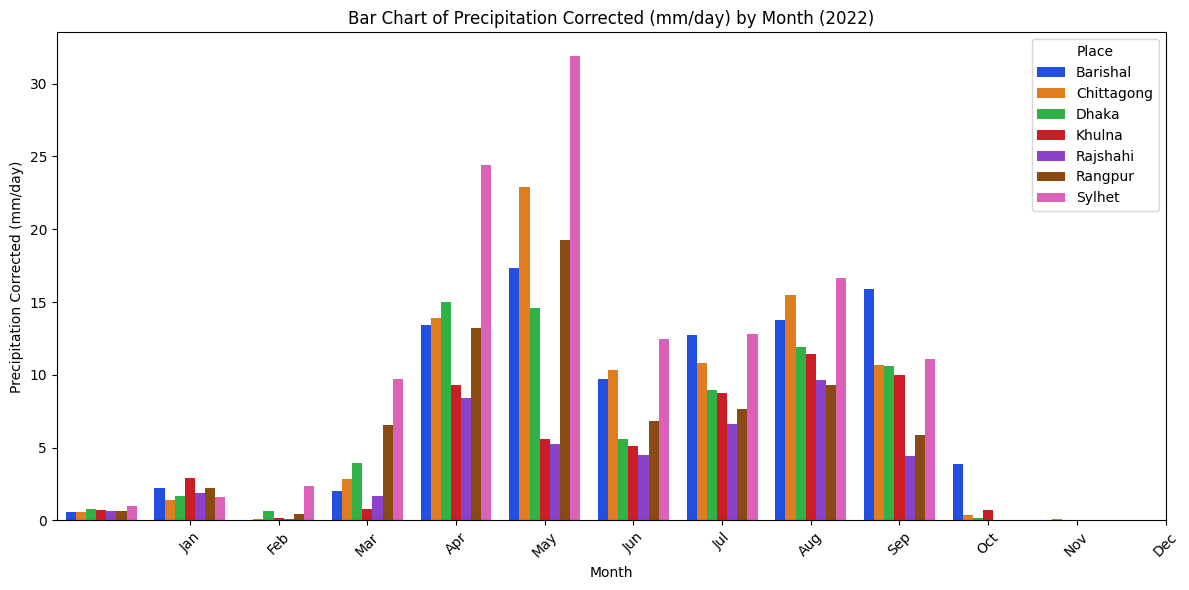

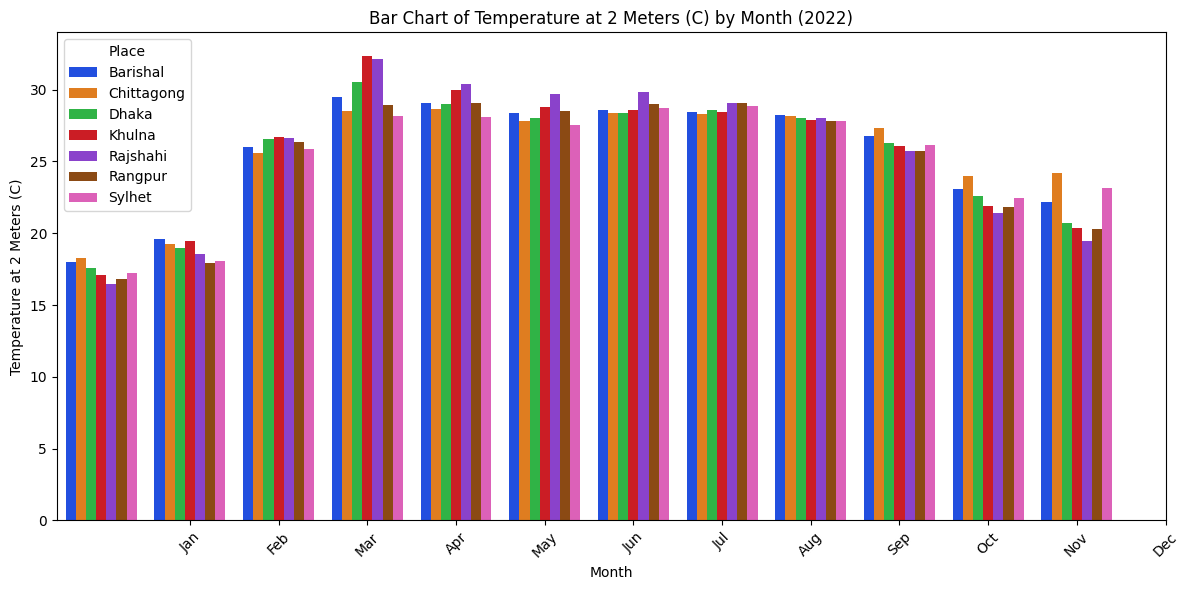

In [21]:
# Extract month and year from the "Date" column
df_pivot['Month'] = df_pivot['Date'].dt.month

# Extract year from the "Date" column
df_pivot['Year'] = df_pivot['Date'].dt.year

# Filter data for the year 2022
df_2022 = df_pivot[df_pivot['Year'] == 2022]
df_2022

# List of parameters in your DataFrame
parameters = df_2022.columns[4:-2]  # Exclude "Month" and "Year" columns

# Group data by month and parameter
grouped = df_2022.groupby(['Month', 'Place'])[parameters].mean().reset_index()

# Set the order of months
month_order = list(range(1, 13))  # January to December

# Set a Seaborn color palette
sns.set_palette("bright")

# Create a bar chart for each parameter, grouped by month
for parameter in parameters:
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Month', y=parameter, hue='Place', data=grouped, order=month_order)
    plt.title(f"Bar Chart of {parameter} by Month (2022)")
    plt.xlabel("Month")
    plt.ylabel(parameter)
    plt.xticks(ticks=month_order, labels=pd.to_datetime(month_order, format='%m').strftime('%b'), rotation=45)
    plt.legend(title="Place")
    plt.tight_layout()
    plt.show()

      Place  Longitude   Latitude       Date  Surface Soil Wetness (1)  \
3592  Dhaka  90.389015  23.764402 2018-01-01                      0.81   
3593  Dhaka  90.389015  23.764402 2018-01-02                      0.81   
3594  Dhaka  90.389015  23.764402 2018-01-03                      0.81   
3595  Dhaka  90.389015  23.764402 2018-01-04                      0.81   
3596  Dhaka  90.389015  23.764402 2018-01-05                      0.80   
...     ...        ...        ...        ...                       ...   
5383  Dhaka  90.389015  23.764402 2022-11-27                      0.73   
5384  Dhaka  90.389015  23.764402 2022-11-28                      0.73   
5385  Dhaka  90.389015  23.764402 2022-11-29                      0.72   
5386  Dhaka  90.389015  23.764402 2022-11-30                      0.71   
5387  Dhaka  90.389015  23.764402 2022-12-01                      0.70   

      Precipitation Corrected (mm/day)  Temperature at 2 Meters (C)  Month  \
3592                             

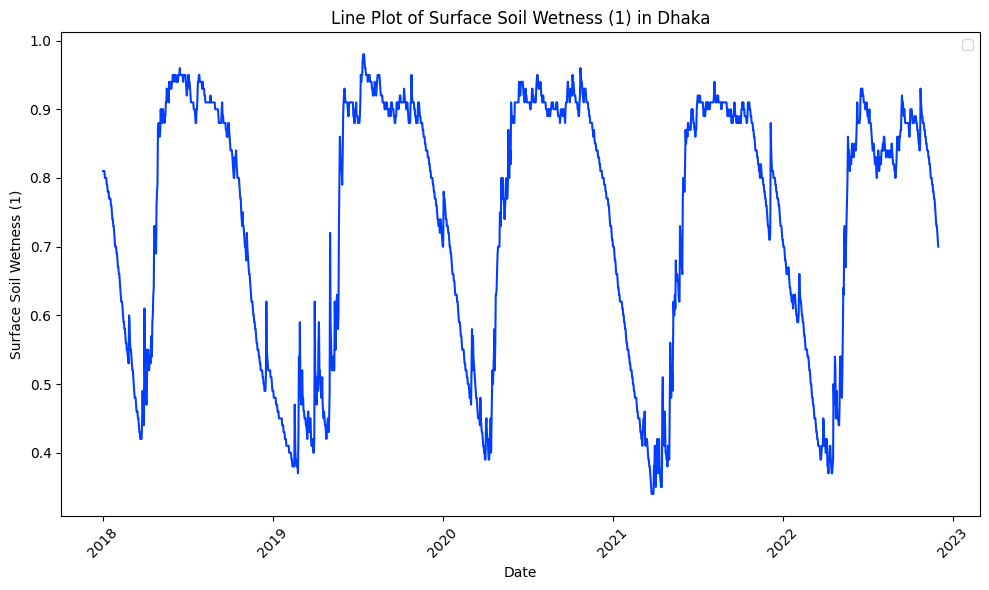

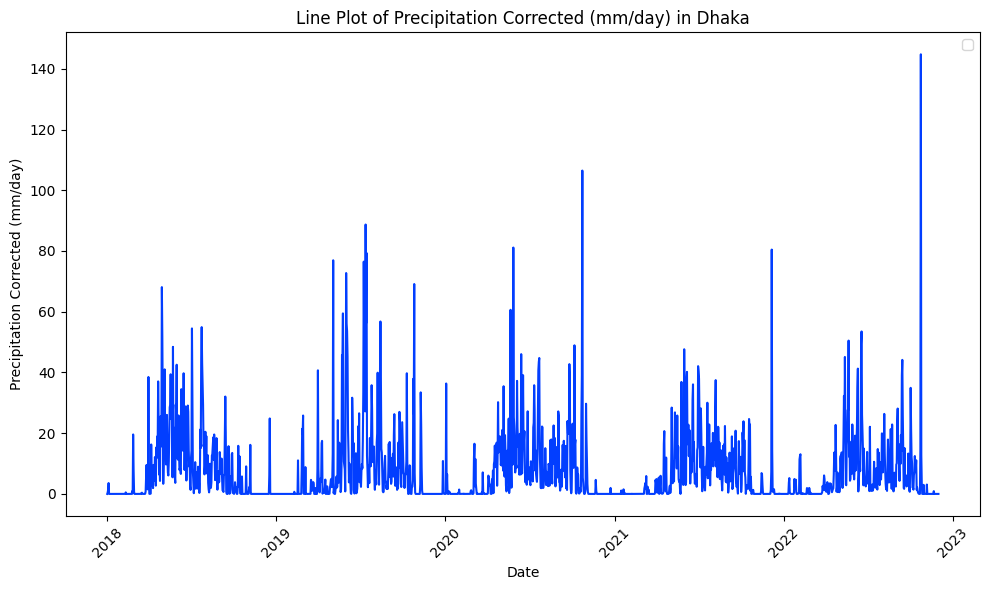

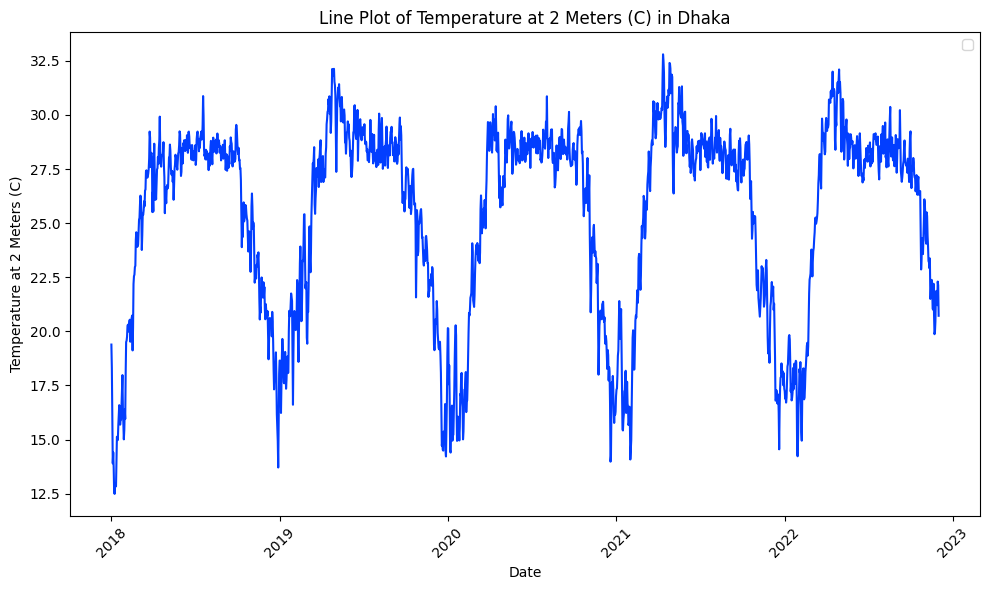

In [22]:
# Filter data for the "Dhaka" location
df_dhaka = df_pivot[df_pivot['Place'] == 'Dhaka']
print(df_dhaka)

# List of parameters in your DataFrame
parameters = df_dhaka.columns[4:-2]  # Exclude "Place", "Longitude", "Latitude", "Date", "Month", and "Year" columns

# Create line plots for each parameter
for parameter in parameters:
    plt.figure(figsize=(10, 6))
    plt.plot(df_dhaka['Date'], df_dhaka[parameter])
    plt.title(f"Line Plot of {parameter} in Dhaka")
    plt.xlabel("Date")
    plt.ylabel(parameter)
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [23]:
pip install pandas numpy xgboost

Forecasting for parameter type: Surface Soil Wetness (1)
Mean Squared Error for Surface Soil Wetness (1): 0.003925957535995419


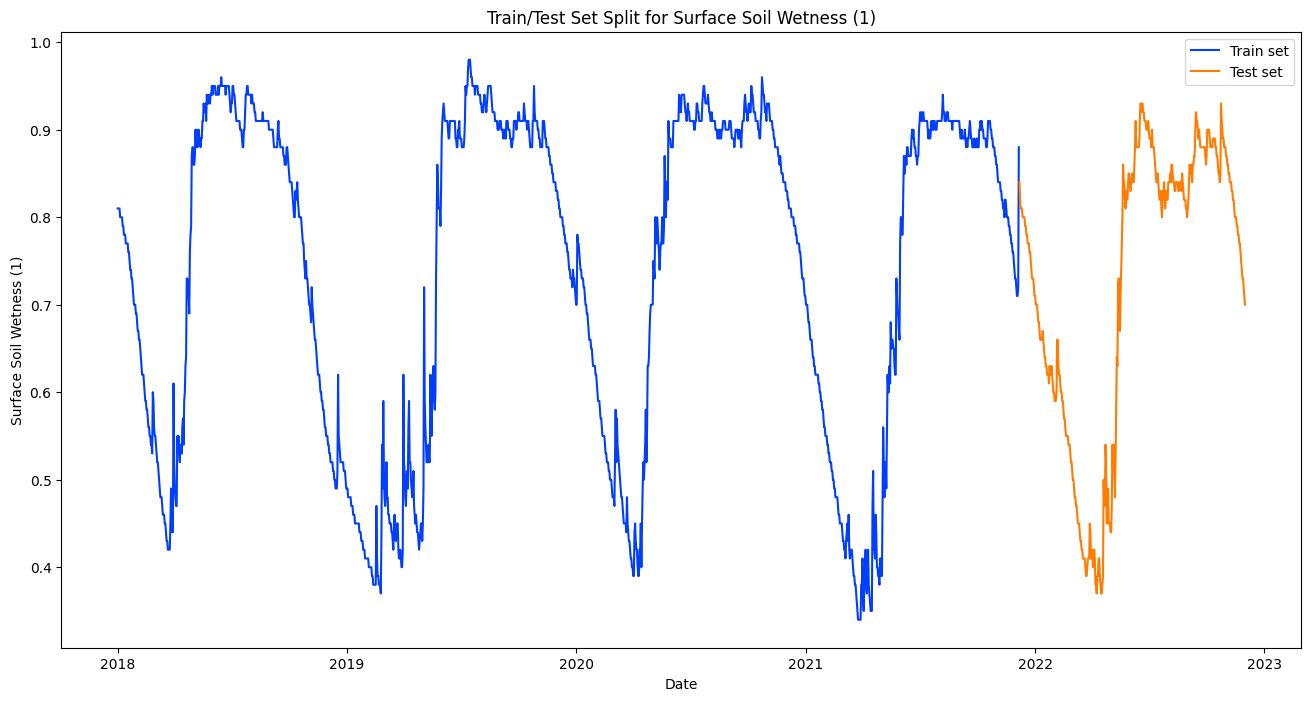

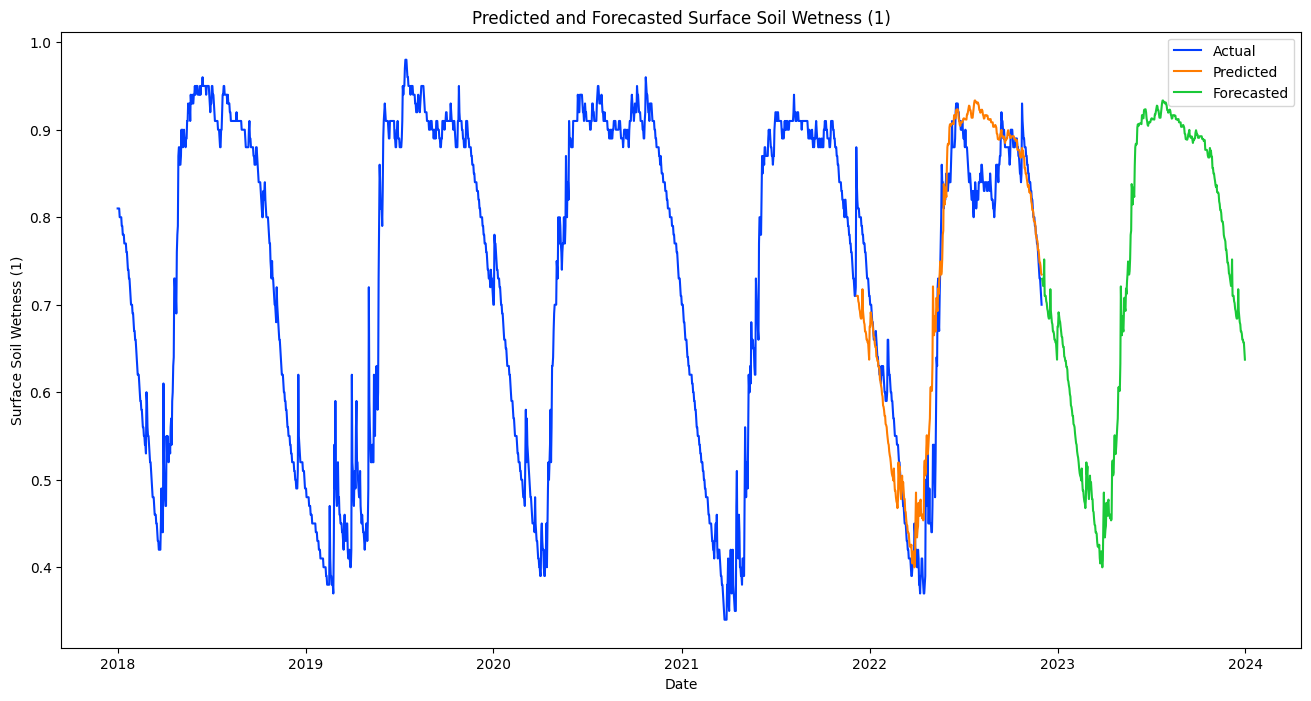

Forecasting for parameter type: Precipitation Corrected (mm/day)
Mean Squared Error for Precipitation Corrected (mm/day): 116.98949615390497


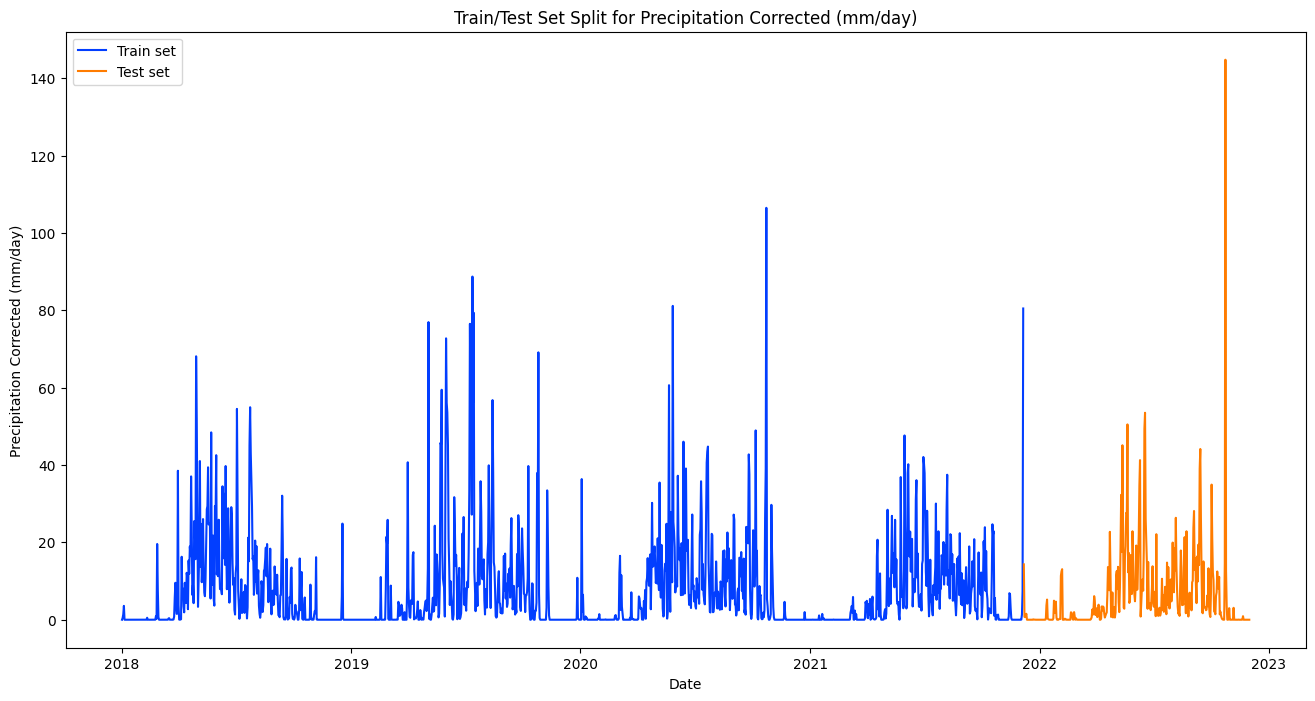

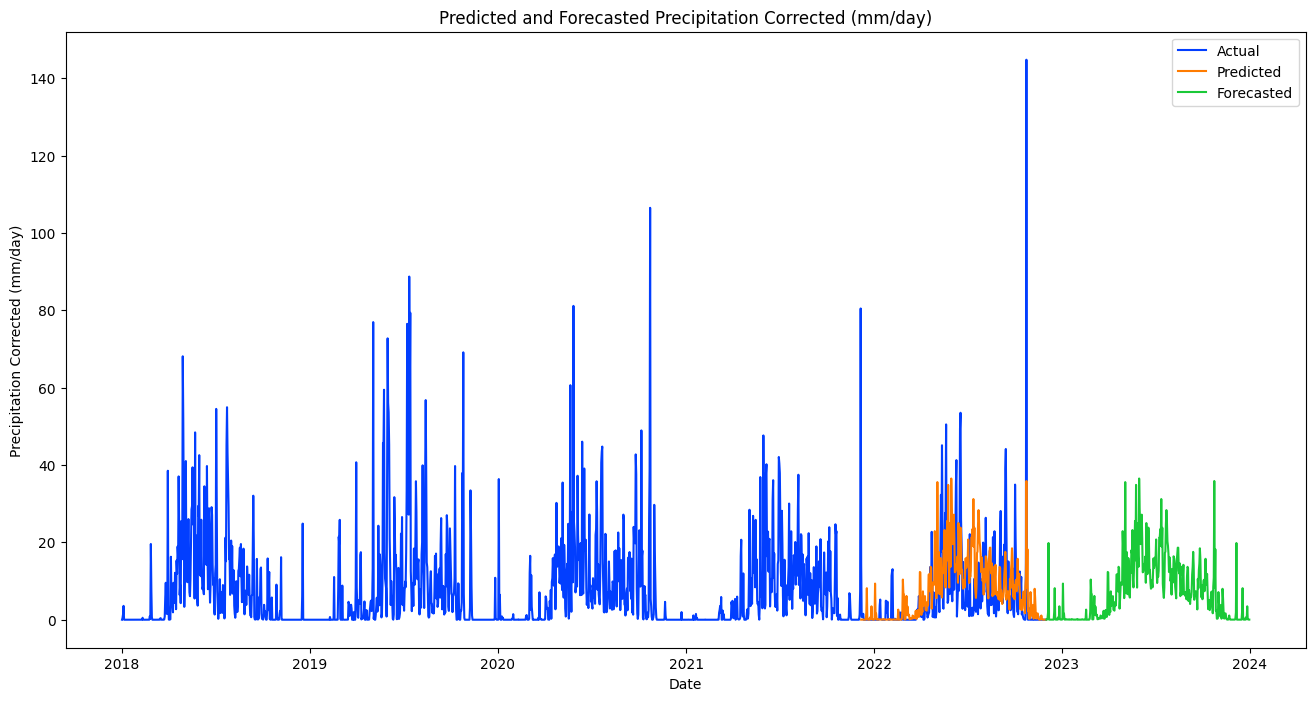

Forecasting for parameter type: Temperature at 2 Meters (C)
Mean Squared Error for Temperature at 2 Meters (C): 1.6729836084041037


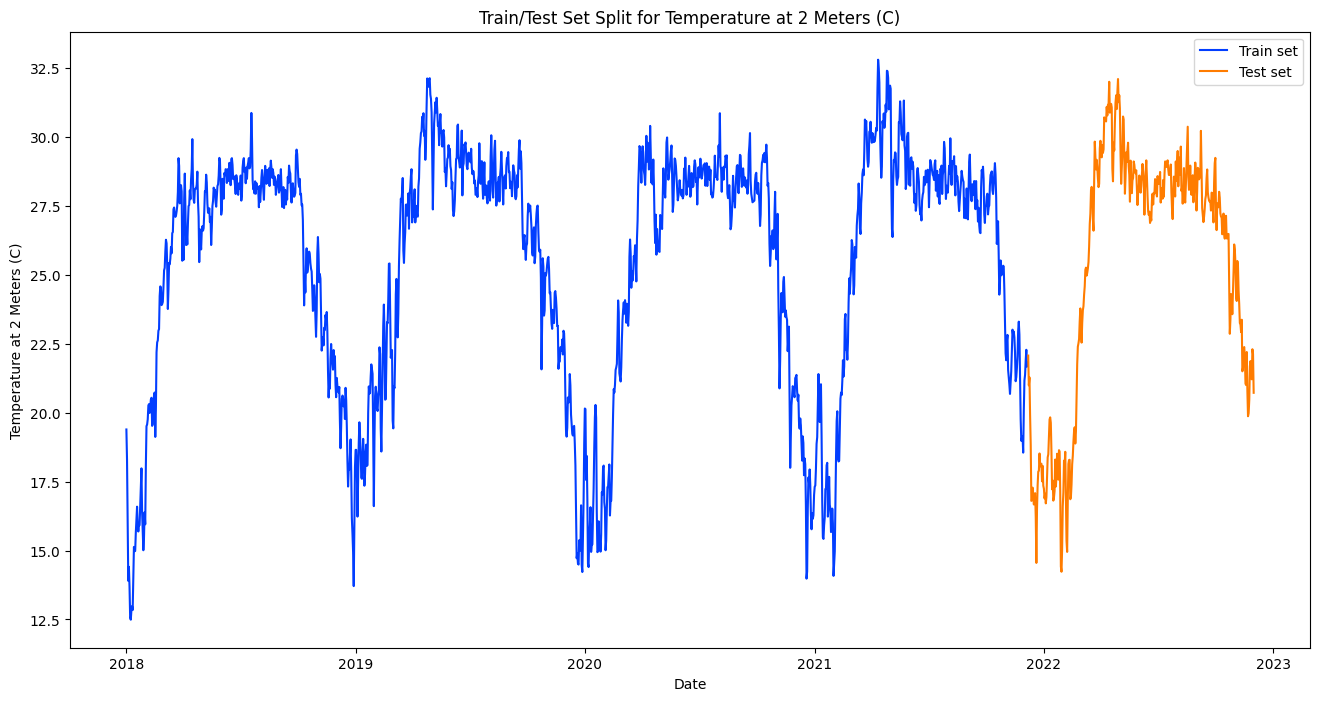

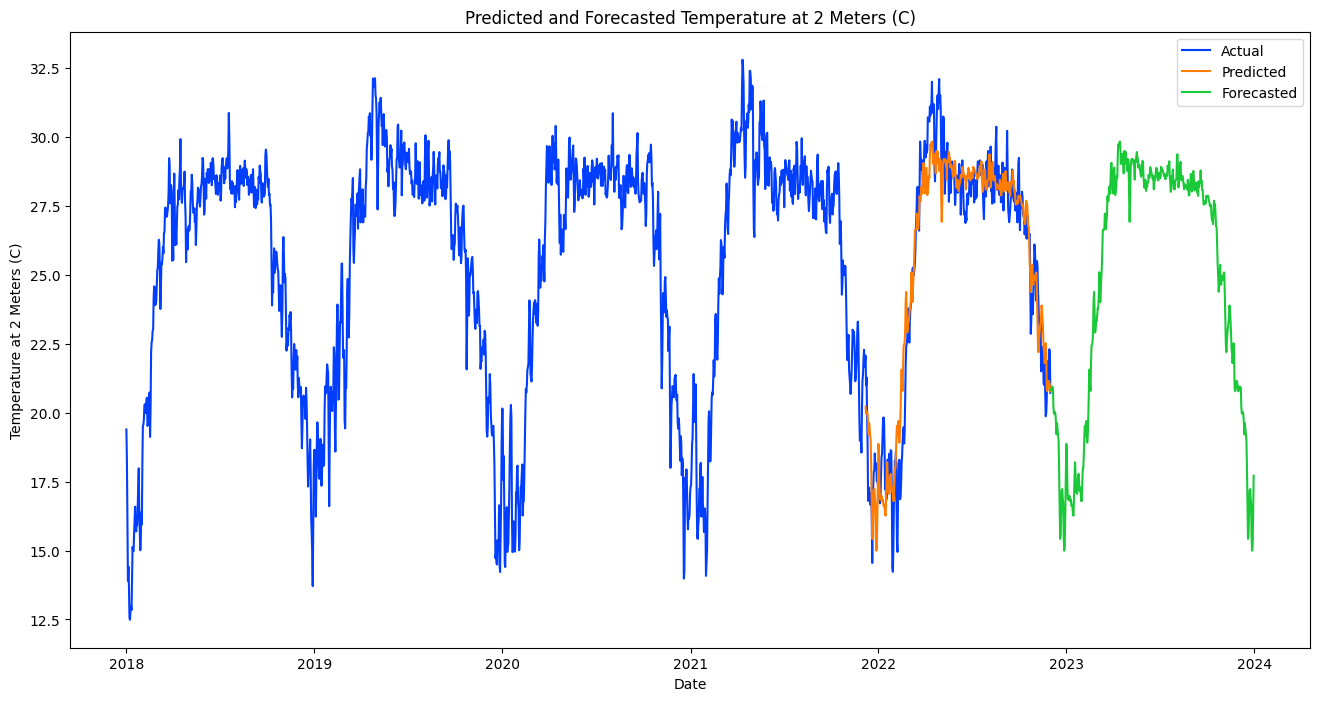

In [24]:
df_pivot["Date"] = pd.to_datetime(df_pivot["Date"])

# Iterate through parameter types
parameter_types = df_dhaka.columns[4:-2]  # Exclude "Place", "Longitude", "Latitude", "Date", "Month", and "Year" columns

# Iterate through parameter types
for param_type in parameter_types:
    print(f"Forecasting for parameter type: {param_type}")

    # Filter data for the parameter type
    param_df = df_dhaka.copy()  # Create a copy to avoid SettingWithCopyWarning

    # Split the data into train (80%) and test (20%) sets
    train_size = int(0.8 * len(param_df))
    train_df = param_df[:train_size]
    test_df = param_df[train_size:]

    # Define features and target variable
    X_train = train_df["Date"].dt.dayofyear.values.reshape(-1, 1)
    y_train = train_df[param_type].values
    X_test = test_df["Date"].dt.dayofyear.values.reshape(-1, 1)
    y_test = test_df[param_type].values


    # Initialize and fit XGBoost model
    model = XGBRegressor()
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Calculate Mean Squared Error for predicted values
    mse_predicted = mean_squared_error(y_test, y_pred)
    print(f"Mean Squared Error for {param_type}: {mse_predicted}")

    # Create a DataFrame with future dates for 2022
    future_dates = pd.date_range(start="2022-12-02", end="2023-12-31", freq="D")
    future = pd.DataFrame({"Date": future_dates})

    # Prepare future features
    future["DayOfYear"] = future["Date"].dt.dayofyear.values

    # Forecast for 2023
    forecast_2023 = model.predict(future["DayOfYear"].values.reshape(-1, 1))

    #Plot test and train set
    plt.figure(figsize=(16, 8))
    plt.plot(train_df["Date"], train_df[param_type], label="Train set")
    plt.plot(test_df["Date"], test_df[param_type], label="Test set")
    plt.xlabel("Date")
    plt.ylabel(param_type)
    plt.title(f"Train/Test Set Split for {param_type}")
    plt.legend()
    plt.show()

    # Plot the results
    plt.figure(figsize=(16, 8))
    plt.plot(param_df["Date"], param_df[param_type], label="Actual")
    plt.plot(test_df["Date"], y_pred, label="Predicted")
    plt.plot(future["Date"], forecast_2023, label="Forecasted")
    plt.xlabel("Date")
    plt.ylabel(param_type)
    plt.title(f"Predicted and Forecasted {param_type}")
    plt.legend()
    plt.show()


Fitting 7 folds for each of 243 candidates, totalling 1701 fits
Mean Squared Error for Predicted Values: 0.003891931803737825


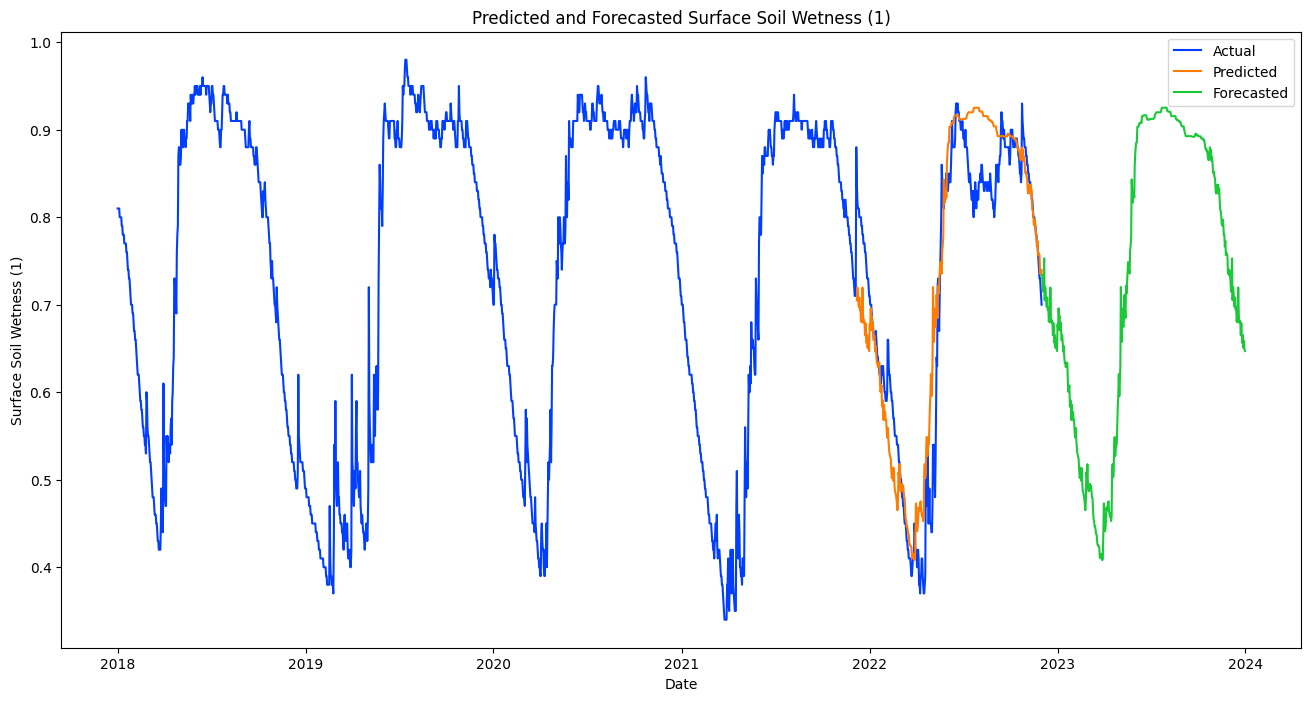

Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 400, 'subsample': 0.9}


In [25]:
# Define features and target variable
X_train = train_df["Date"].dt.dayofyear.values.reshape(-1, 1)
y_train = train_df["Surface Soil Wetness (1)"].values
X_test = test_df["Date"].dt.dayofyear.values.reshape(-1, 1)
y_test = test_df["Surface Soil Wetness (1)"].values

# Define the parameter grid for GridSearchCV
param_grid = {
    "n_estimators": [300, 400, 500],
    "learning_rate": [0.1, 0.5, 0.8],
    "max_depth": [5, 6, 7],
    "subsample": [0.8, 0.9, 1.0],
    "colsample_bytree": [0.8, 0.9, 1.0]
}

# Initialize the XGBoost model
model = XGBRegressor()

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # Use negative MSE for optimization
    cv=7,  # Use 5-fold cross-validation
    verbose=2,
    n_jobs=-1
)

# Fit the GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Get the best model from the GridSearchCV
best_model = grid_search.best_estimator_

# Make predictions on the test set using the best model
y_pred = best_model.predict(X_test)

# Calculate Mean Squared Error for predicted values
mse_predicted = mean_squared_error(y_test, y_pred)
print("Mean Squared Error for Predicted Values:", mse_predicted)

# Create a DataFrame with future dates for 2022
future_dates = pd.date_range(start="2022-12-02", end="2023-12-31", freq="D")
future = pd.DataFrame({"Date": future_dates})

# Prepare future features
future["DayOfYear"] = future["Date"].dt.dayofyear.values.reshape(-1, 1)

# Forecast for 2022 using the best model
forecast_2022 = best_model.predict(future["DayOfYear"].values.reshape(-1, 1))

# Rest of your code for plotting
plt.figure(figsize=(16, 8))
plt.plot(df_dhaka["Date"], df_dhaka["Surface Soil Wetness (1)"], label="Actual")
plt.plot(test_df["Date"], y_pred, label="Predicted")
plt.plot(future["Date"], forecast_2022, label="Forecasted")
plt.xlabel("Date")
plt.ylabel("Surface Soil Wetness (1)")
plt.title("Predicted and Forecasted Surface Soil Wetness (1)")
plt.legend()
plt.show()

# Print the best parameters found by GridSearchCV
print("Best Parameters:", grid_search.best_params_)

Fitting 7 folds for each of 243 candidates, totalling 1701 fits
Mean Squared Error for Predicted Values: 115.90252512041921


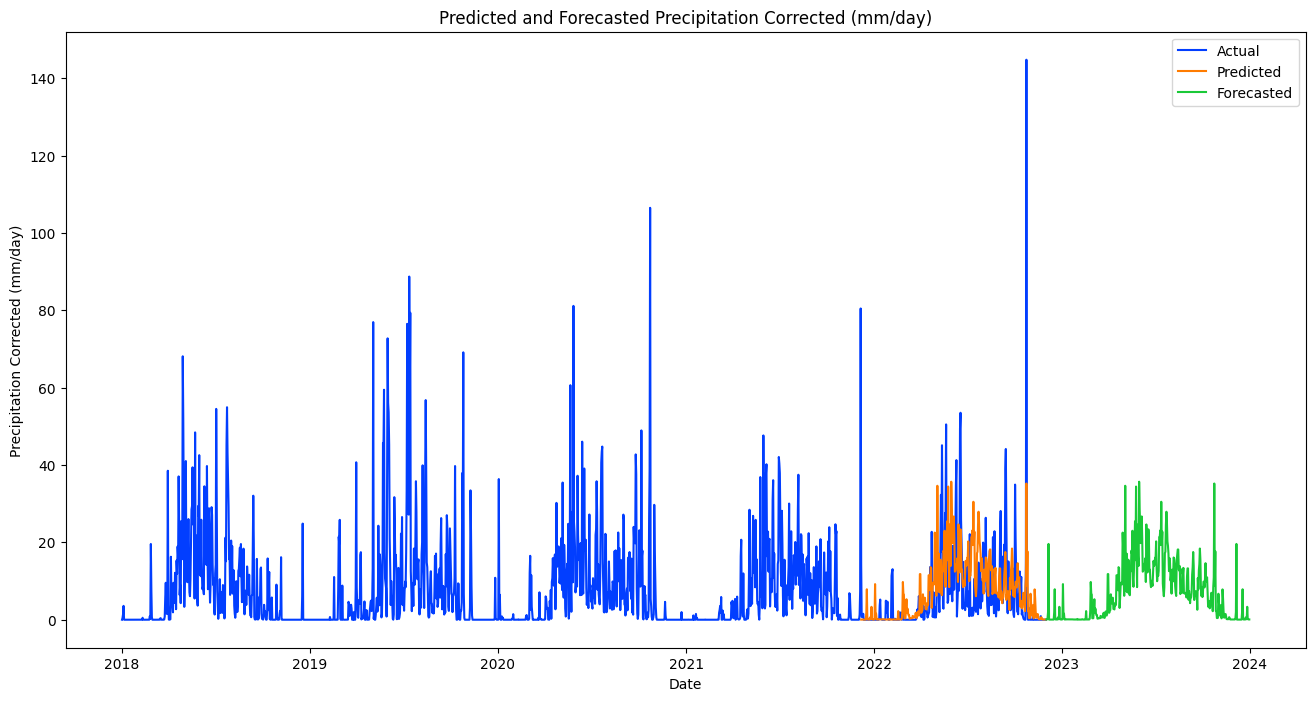

Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'subsample': 1.0}


In [26]:
# Define features and target variable
X_train = train_df["Date"].dt.dayofyear.values.reshape(-1, 1)
y_train = train_df["Precipitation Corrected (mm/day)"].values
X_test = test_df["Date"].dt.dayofyear.values.reshape(-1, 1)
y_test = test_df["Precipitation Corrected (mm/day)"].values

# Define the parameter grid for GridSearchCV
param_grid = {
    "n_estimators": [300, 400, 500],
    "learning_rate": [0.1, 0.5, 0.8],
    "max_depth": [5, 6, 7],
    "subsample": [0.8, 0.9, 1.0],
    "colsample_bytree": [0.8, 0.9, 1.0]
}

# Initialize the XGBoost model
model = XGBRegressor()

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # Use negative MSE for optimization
    cv=7,  # Use 5-fold cross-validation
    verbose=2,
    n_jobs=-1
)

# Fit the GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Get the best model from the GridSearchCV
best_model = grid_search.best_estimator_

# Make predictions on the test set using the best model
y_pred = best_model.predict(X_test)

# Calculate Mean Squared Error for predicted values
mse_predicted = mean_squared_error(y_test, y_pred)
print("Mean Squared Error for Predicted Values:", mse_predicted)

# Create a DataFrame with future dates for 2022
future_dates = pd.date_range(start="2022-12-02", end="2023-12-31", freq="D")
future = pd.DataFrame({"Date": future_dates})

# Prepare future features
future["DayOfYear"] = future["Date"].dt.dayofyear.values.reshape(-1, 1)

# Forecast for 2022 using the best model
forecast_2022 = best_model.predict(future["DayOfYear"].values.reshape(-1, 1))

# Rest of your code for plotting
plt.figure(figsize=(16, 8))
plt.plot(df_dhaka["Date"], df_dhaka["Precipitation Corrected (mm/day)"], label="Actual")
plt.plot(test_df["Date"], y_pred, label="Predicted")
plt.plot(future["Date"], forecast_2022, label="Forecasted")
plt.xlabel("Date")
plt.ylabel("Precipitation Corrected (mm/day)")
plt.title("Predicted and Forecasted Precipitation Corrected (mm/day)")
plt.legend()
plt.show()

# Print the best parameters found by GridSearchCV
print("Best Parameters:", grid_search.best_params_)



Fitting 7 folds for each of 243 candidates, totalling 1701 fits
Mean Squared Error for Predicted Values: 1.6554430708428964


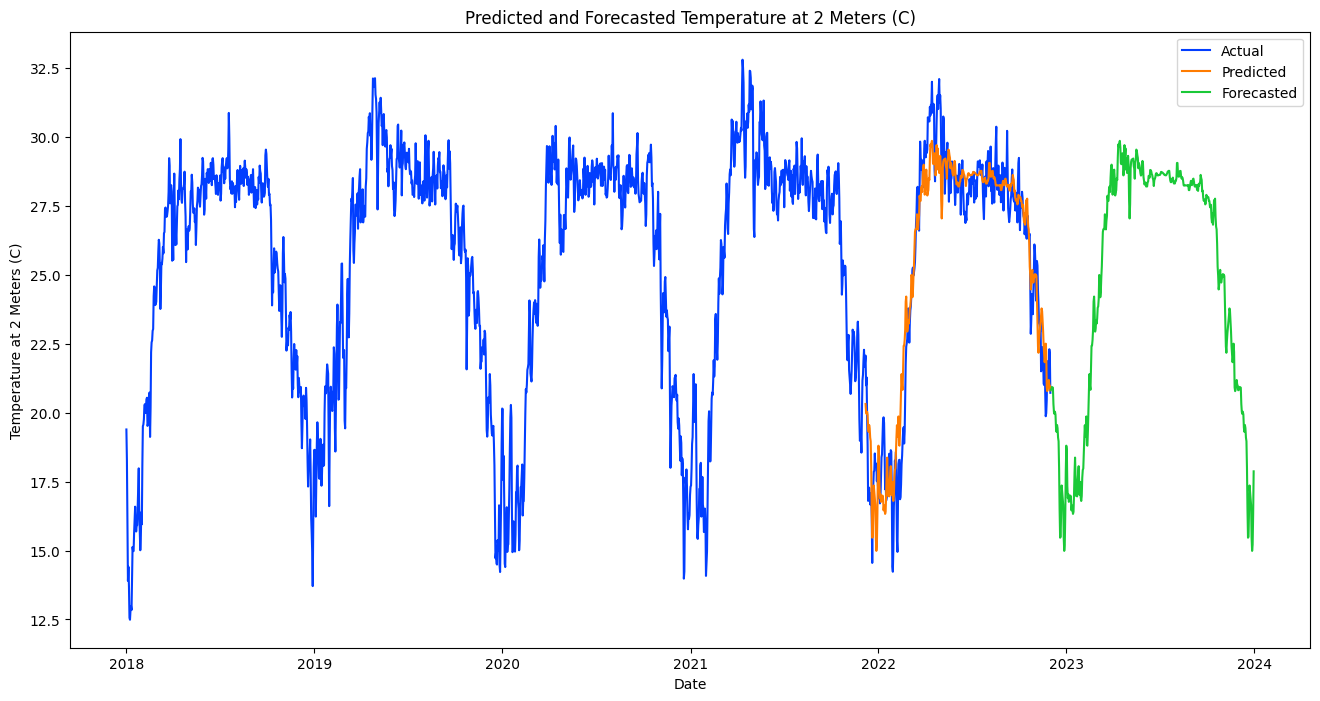

Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 400, 'subsample': 0.9}


In [27]:
# Define features and target variable
X_train = train_df["Date"].dt.dayofyear.values.reshape(-1, 1)
y_train = train_df["Temperature at 2 Meters (C)"].values
X_test = test_df["Date"].dt.dayofyear.values.reshape(-1, 1)
y_test = test_df["Temperature at 2 Meters (C)"].values

# Define the parameter grid for GridSearchCV
param_grid = {
    "n_estimators": [300, 400, 500],
    "learning_rate": [0.1, 0.5, 0.8],
    "max_depth": [5, 6, 7],
    "subsample": [0.8, 0.9, 1.0],
    "colsample_bytree": [0.8, 0.9, 1.0]
}

# Initialize the XGBoost model
model = XGBRegressor()

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # Use negative MSE for optimization
    cv=7,  # Use 5-fold cross-validation
    verbose=2,
    n_jobs=-1
)

# Fit the GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Get the best model from the GridSearchCV
best_model = grid_search.best_estimator_

# Make predictions on the test set using the best model
y_pred = best_model.predict(X_test)

# Calculate Mean Squared Error for predicted values
mse_predicted = mean_squared_error(y_test, y_pred)
print("Mean Squared Error for Predicted Values:", mse_predicted)

# Create a DataFrame with future dates for 2022
future_dates = pd.date_range(start="2022-12-02", end="2023-12-31", freq="D")
future = pd.DataFrame({"Date": future_dates})

# Prepare future features
future["DayOfYear"] = future["Date"].dt.dayofyear.values.reshape(-1, 1)

# Forecast for 2022 using the best model
forecast_2022 = best_model.predict(future["DayOfYear"].values.reshape(-1, 1))

# Rest of your code for plotting
plt.figure(figsize=(16, 8))
plt.plot(df_dhaka["Date"], df_dhaka["Temperature at 2 Meters (C)"], label="Actual")
plt.plot(test_df["Date"], y_pred, label="Predicted")
plt.plot(future["Date"], forecast_2022, label="Forecasted")
plt.xlabel("Date")
plt.ylabel("Temperature at 2 Meters (C)")
plt.title("Predicted and Forecasted Temperature at 2 Meters (C)")
plt.legend()
plt.show()

# Print the best parameters found by GridSearchCV
print("Best Parameters:", grid_search.best_params_)